## Marketing Exploratory Data Analysis
### Notebook by Kymberly Ayodeji

### Step 0: Install Libraries and Packages

In [108]:
# Basic Numerical Libraries
import pandas as pd
import numpy as np

# Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Step 1: Load Data

In [109]:
data = pd.read_csv("data/CDNOW_master.txt", sep="\s+", names=["customer_id", "date", "quantity", "price"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\kymno\AppData\Local\Temp\ipykernel_11504\1906795430.py:1: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv("data/CDNOW_master.txt", sep="\s+", names=["customer_id", "date", "quantity", "price"])


#### 1.0: Notes:
* 69,659 rows and 4 columns
* No null entries
* date column is of type int65 and will need to be converted to datetime

In [110]:
# Convert date column to string and then to datetime object
data = data \
    .assign(date = lambda x: x['date'].astype(str)) \
    .assign(date = lambda x: pd.to_datetime(x['date'])) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


### 2.0 Initial Exploratory Analysis
- 2.1 Numerical descriptions
- 2.2 Graphical distributions
- 2.3 Handling of any outliers
- 2.4 Correlation Analysis

In [111]:
# 2.1 
qp = ['quantity','price'] # identifying the numerical columns
data[qp].describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,69659.0,2.410040,2.333924,1.0,1.00,2.00,3.0,99.00
price,69659.0,35.893648,36.281942,0.0,14.49,25.98,43.7,1286.01


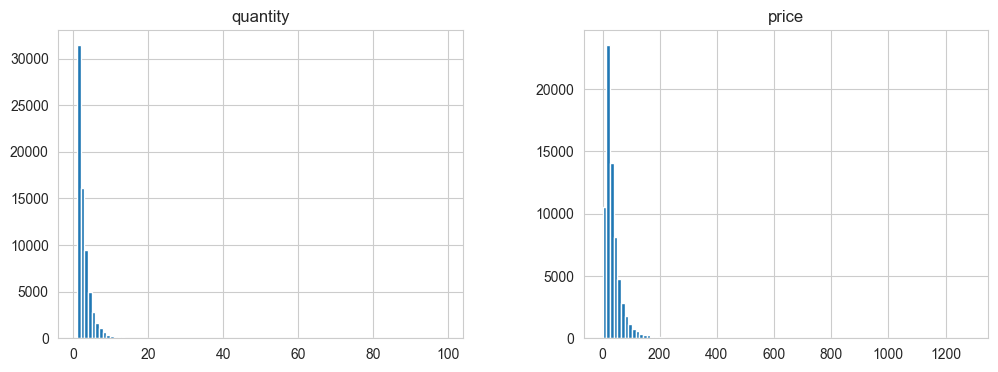

In [114]:
#2.2
data[qp].hist(bins=100, figsize=(12, 4), layout=(1, 2));

In [128]:
print(f"Skewness: Quantity {data['quantity'].skew():.2f}, Price {data['price'].skew():.2f}")

Skewness: Quantity 5.86, Price 5.66


Both numerical features are quite skewed with several outliers. Lets see if a log transform can adress the skewness.

<Axes: ylabel='Count'>

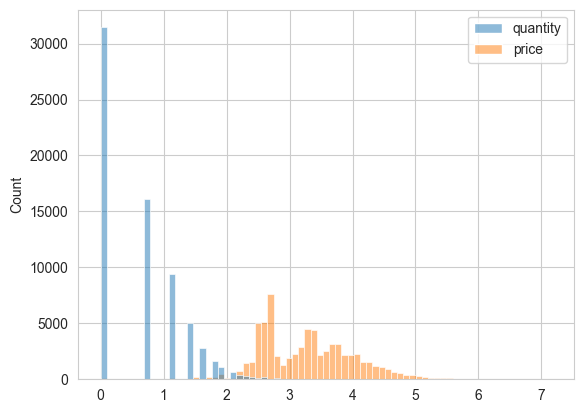

In [116]:
log_data = data[qp].map(lambda i: np.log(i) if i > 0 else 0)
sns.histplot(log_data )

In [117]:
# Outliers
des_data = data[qp].describe().T
# compute IQR and 1.5 * IQR
des_data['IQR'] = des_data['75%'] - des_data['25%']
des_data['1.5_IQR']= 1.5*des_data['IQR']
    
# establish outlier bounds
des_data['u_outlier_bound'] = des_data['75%'] + des_data['1.5_IQR']
des_data

,count,mean,std,min,25%,50%,75%,max,IQR,1.5_IQR,u_outlier_bound
quantity,69659.0,2.410040,2.333924,1.0,1.00,2.00,3.0,99.00,2.00,3.000,6.000
price,69659.0,35.893648,36.281942,0.0,14.49,25.98,43.7,1286.01,29.21,43.815,87.515


In [129]:
# Use outlier bounds to determine how many outliers are there for quantity and price
quantity_outliers_count=data[data['quantity']>des_data['u_outlier_bound'].quantity].count()['quantity']
price_outliers_count=data[data['price']>des_data['u_outlier_bound'].price].count()['price']
print(f"Number of quantity outliers =  {quantity_outliers_count} ({100*quantity_outliers_count/data.shape[0]:.2f}%)")
print(f"Number of price outliers - {price_outliers_count} ({100*price_outliers_count/data.shape[0]:.2f}%)")

Number of quantity outliers =  3257 (4.68%)
Number of price outliers - 4439 (6.37%)


In [139]:
# Drop outliers from dataframe and compare with original dataframe
df_no_outliers = data.drop(data[ \
    (data['quantity']>des_data['u_outlier_bound'].quantity) | \
    (data['price']>des_data['u_outlier_bound'].price) \
    ].index)
df_no_outliers[qp].describe().T


,count,mean,std,min,25%,50%,75%,max
quantity,64910.0,1.987768,1.234984,1.0,1.00,2.00,3.00,6.00
price,64910.0,28.843702,18.238490,0.0,14.37,24.48,39.33,87.51


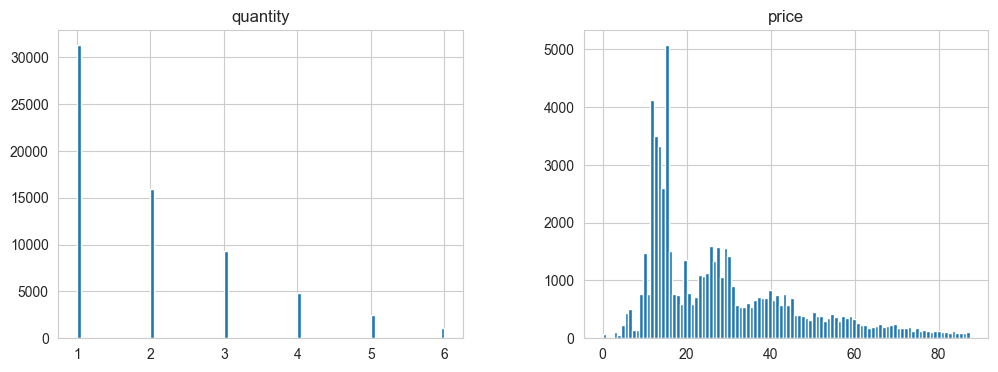

In [140]:
df_no_outliers[qp].hist(bins=100, figsize=(12, 4), layout=(1, 2));

2.3 Results: Removing the outliers didn't significantly change the distrubtion shape of the quantity and price. Since the outliers are not a significant amount (leass than 7% of the dataset) and are plausible dataset values, I am choosing not to remove them. I may reconsider as they could seriously impact future sampling and regression techniques.

In [142]:
# 2.4 Correlation
corr_map = data[qp].corr()
corr_map


,quantity,price
quantity,1.00000,0.90141
price,0.90141,1.00000


2.4 Results: Quantity and Price are highly correlated, which is expected